<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=300 height=300 align=left class="saturate" >

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2024<br>
<div dir=ltr align=center>

<font color=3C99D size=5>
Reinforcement Learning <br>



Although in many cases classic RL algorithms such as  QLearning perform pretty well, there are also cases where they can fall short. In this notebook we will explore these shortcomings while also introducing more effective variants for such algorithms.

# Q-Learning vs. Deep Q-Learning

### Q-Learning

**Q-Learning** is a model-free reinforcement learning algorithm used to learn the optimal action-value function $ Q(s, a) $ for a given environment. It operates by iteratively updating $ Q $-values using the Bellman equation, based on the rewards received and the agent's estimate of future rewards. Q-learning is effective in small, discrete state-action spaces where a table can be used to store $ Q $-values. However, as the size or complexity of the environment grows, maintaining and updating a table for all state-action pairs becomes computationally infeasible, and the algorithm struggles to generalize across states.

### Deep Q-Learning

**Deep Q-Learning (DQN)** addresses these limitations by approximating the $ Q $-value function using a deep neural network. Instead of storing $ Q(s, a) $ values in a table, the neural network takes a state $ s $ as input and outputs $ Q $-values for all possible actions. This allows DQN to handle environments with large or continuous state spaces, such as video games or robotics tasks. Deep Q-learning also introduces techniques like experience replay and target networks to stabilize training. DQN is particularly needed in scenarios where the state space is high-dimensional, such as pixel-based input (e.g., images from a game), where tabular methods are impractical, and learning representations through a neural network is necessary for effective decision-making.


Here we will implement both Q-Learning and Deep Q-Learning on the environment `LunarLander-v2`. This environment consists of a Discrete action space with four possible actions:

0: do nothing

1: fire left orientation engine

2: fire main engine

3: fire right orientation engine

The state space however consists of 8-dimensional continuous states: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not. The continuity of the state space lets us use a neural network to estimate $Q$-values as a function with state as input and $Q$-values for all actions.

# Libraries

In [67]:
!sudo apt-get update --quiet
!pip install imageio --quiet
!sudo apt-get install -y xvfb ffmpeg --quiet
!pip install swig --quiet
!pip install gymnasium[box2d] --quiet
! pip install gymnasium
! pip install gymnasium[box2d]
from IPython.display import clear_output
clear_output()

Import the neccesary libraries here.

In [68]:
import gymnasium as gym
import random
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from collections import namedtuple, deque

import base64
import json
import imageio
import IPython

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import random
import time
from IPython.display import clear_output, HTML
from base64 import b64encode
from moviepy.editor import ImageSequenceClip
from typing import Tuple


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

These are some helper functions that can visualize the outcome of a sampled trajectory. They will be useful later.

In [69]:
import logging
logging.getLogger().setLevel(logging.ERROR)

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)


def plot_rewards(sum_of_rewards, show_result=False):
    plt.figure(1)
    rewards = torch.tensor(sum_of_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 50 episode averages and plot them too
    length = len(rewards)
    init_len = min(49, length)
    init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))
    if length > 50:
        means = rewards.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((init_means, means))
    else:
        means = init_means
    plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)


def create_policy_eval_video(env, agent, filename, num_episodes=1, fps=30):
    """
    Creates a video of the agent interacting with the environment using its policy.
    Args:
        env: The environment to evaluate.
        agent: The agent to evaluate.
        filename: The name of the video file to save.
        num_episodes: Number of episodes to record.
        fps: Frames per second for the video.
    Returns:
        HTML object for embedding the video in Jupyter Notebook.
    """
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state, _ = env.reset()
            video.append_data(env.render())
            done = False
            while not done:
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(agent.device)
                action = agent.act(state_tensor, greedy=True)  # Select greedy action
                next_state, reward, terminated, truncated, _ = env.step(action)  # Removed .item()
                done = terminated or truncated
                video.append_data(env.render())
                state = next_state

    # Return video for display
    with open(filename, 'rb') as f:
        video_data = f.read()
    b64_video = base64.b64encode(video_data).decode()
    return HTML(f"""
        <video width="640" height="480" controls>
            <source src="data:video/mp4;base64,{b64_video}" type="video/mp4">
        </video>
    """)

def save_progress(sum_of_rewards, PATH):
    # Convert the list to a JSON string
    json_data = json.dumps(sum_of_rewards)
    # Write the JSON data to a file
    with open(PATH + str('.json'), "w") as file:
        file.write(json_data)


def load_progress(PATH):
    with open(PATH + str('.json'), "r") as file:
        json_data = file.read()
    # Load the JSON data back into a Python list
    return json.loads(json_data)

# Q-Learning

Here you should implement the `QLearningAgent` class. Note that since the state space is continuous, you will need to discretize states as some state bins in order to use the classic Q-Learning algorithm (number of bins is optional).

In [70]:
class QLearningAgent(object):
    def __init__(self, env, learning_rate, discount_factor, epsilon, epsilon_decay, epsilon_min, state_bins):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.state_bins = state_bins
        self.q_table = np.zeros([*(len(bins) + 1 for bins in state_bins), env.action_space.n])

    def discretize_state(self, state):
        """
        Discretizes a continuous state into discrete bins.
        """
        discrete_state = []
        for dim, bins in zip(state, self.state_bins):
            discrete_state.append(np.digitize(dim, bins))
        return tuple(discrete_state)

    def act(self, state, greedy=True):
        """
        Selects an action based on epsilon-greedy policy.
        """
        discrete_state = self.discretize_state(state)
        if greedy or np.random.rand() > self.epsilon:
            return np.argmax(self.q_table[discrete_state])
        else:
            return self.env.action_space.sample()

    def update_q_value(self, state, action, reward, next_state, done):
        """
        Updates the Q-value for the given state-action pair.
        """
        discrete_state = self.discretize_state(state)
        discrete_next_state = self.discretize_state(next_state)

        target = reward
        if not done:
            target += self.discount_factor * np.max(self.q_table[discrete_next_state])

        self.q_table[discrete_state][action] += self.learning_rate * (target - self.q_table[discrete_state][action])

    def decay_epsilon(self):
        """
        Decays epsilon for exploration.
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def train(self, num_episodes):
        """
        Train the agent for a specified number of episodes.
        """
        rewards = []
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            total_reward = 0
            done = False

            while not done:
                action = self.act(state, greedy=False)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                self.update_q_value(state, action, reward, next_state, done)
                total_reward += reward
                state = next_state

            self.decay_epsilon()
            rewards.append(total_reward)

            if (episode + 1) % 100 == 0:
                print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {self.epsilon:.3f}")

        return rewards

# Deep Q-Network

In this part, you need to implement a deep q-network (DQN). When implementing DQN it's common to use a replay buffer. A replay buffer in deep reinforcement learning stores past experiences so the agent can sample them randomly during training. This helps break correlations in sequential data, improves sample efficiency by reusing experiences, stabilizes training by providing a consistent data distribution, and reduces the variance in gradient updates. The class `ReplayBuffer` code is given to you. Push the trajectory to the buffer while training the network and sample from it when updating the network.


<p align="center">
  <img src="https://www.researchgate.net/publication/346346921/figure/fig5/AS:962138164178960@1606403022784/llustration-of-the-replay-buffer-in-the-RL.ppm" alt="Replay Buffer Illustration" width="600">
</p>


In [71]:
class ReplayBuffer:
    def __init__(self, capacity, batch_size):
        self.memory = deque([], maxlen=capacity)
        self.batch_size = batch_size
        self.experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'done'))

    def push(self, state, action, reward, next_state, done):
        new_experience = self.experience(
            state=torch.tensor(state, dtype=torch.float32).unsqueeze(0),
            action=torch.tensor([action], dtype=torch.int64),
            reward=torch.tensor([reward], dtype=torch.float32),
            next_state=torch.tensor(next_state, dtype=torch.float32).unsqueeze(0),
            done=torch.tensor([done], dtype=torch.bool)
        )
        self.memory.append(new_experience)

    def sample(self):
        experiences = random.sample(self.memory, self.batch_size)
        states = torch.cat([e.state for e in experiences])
        actions = torch.cat([e.action for e in experiences])
        rewards = torch.cat([e.reward for e in experiences])
        next_states = torch.cat([e.next_state for e in experiences])
        dones = torch.cat([e.done for e in experiences])
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)


In this part we must design our Agent class which is the must important part of the notebook. First let's take a look at its methods:


*   `__init__` : initializes the agent, by receiving it the q_network, replay memory, optimize, criterion, and a dictionary of paramters which hold the hyperparameters of the agent.
*   `step` : allows the agent to store an experience in its memory and if necessary, it initiates the learning process.
*   `act` : by receiving a state and boolean value for choosing a greedy action, if the boolean value is false, it selects an $\varepsilon$-greedy action by passing the state to the policy network of the agent, and select the action with the highest state-action value. The $\varepsilon$ value is calculated using the following formula: $$\varepsilon = \varepsilon_{end} + \left(\varepsilon_{start} - \varepsilon_{end}\right)\exp\left(-\frac{\text{steps done}}{\text{decay rate}}\right)$$
*   `learn` : first computes the predicted Q-values for the observed states and actions using the policy network. Then, it computes the expected Q-values for the next states by evaluating the target network, incorporating rewards and discount factors. After computing the loss between predicted and expected Q-values, the function optimizes the model parameters using gradient descent. Additionally, it calls the soft update function to gradually update the target network's parameters towards the policy network's parameters.
*   `soft_update` : The target network is updated at every step with a soft update controlled by the hyperparameter $\tau$, which was previously defined. The target is updated according to: $$\theta' \leftarrow \tau \theta + (1 - \tau) \theta'$$ where $\theta'$ are the parameters of the target network and $\theta$ are the parameters of the policy network.
*   `save` and `load` : are used for saving and loading the policy and target networks of the agent.

In [72]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers):
        super(QNetwork, self).__init__()
        layers = []
        for i in range(len(hidden_layers)):
            layers.append(nn.Linear(input_dim if i == 0 else hidden_layers[i - 1], hidden_layers[i]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [73]:
class DQLearningAgent:
    def __init__(self, q_network, memory, optimizer, criterion, params, env):
        self.policy_net = q_network.to(params['DEVICE'])
        self.target_net = q_network.to(params['DEVICE'])
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.memory = memory
        self.criterion = criterion
        self.optimizer = optimizer(self.policy_net.parameters(), lr=params['LR'])

        self.gamma = params['GAMMA']
        self.tau = params['TAU']
        self.epsilon = params['EPS_START']
        self.eps_end = params['EPS_END']
        self.eps_decay = params['EPS_DECAY']
        self.update_rate = params['UPDATE_RATE']
        self.env = env
        self.device = params['DEVICE']
        self.steps_done = 0

    def act(self, state, greedy=False):
        eps_threshold = self.eps_end + (self.epsilon - self.eps_end) * np.exp(-self.steps_done / self.eps_decay)
        if greedy or np.random.rand() > eps_threshold:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
                q_values = self.policy_net(state_tensor)
                return q_values.argmax(dim=-1).item()
        return self.env.action_space.sample()

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        self.steps_done += 1

        if len(self.memory) >= self.memory.batch_size and self.steps_done % self.update_rate == 0:
            self.learn()

    def learn(self):
        states, actions, rewards, next_states, dones = self.memory.sample()

        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)

        q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(dim=1)[0]
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones.float())

        loss = self.criterion(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update()

    def soft_update(self):
        for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(self.tau * policy_param.data + (1.0 - self.tau) * target_param.data)

    def train(self, num_episodes):
        rewards = []

        for episode in range(1, num_episodes + 1):
            state, _ = self.env.reset()
            total_reward = 0
            done = False

            while not done:
                action = self.act(state, greedy=False)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated

                self.step(state, action, reward, next_state, done)
                total_reward += reward
                state = next_state

            self.epsilon = max(self.eps_end, self.epsilon * self.eps_decay)
            rewards.append(total_reward)

            if episode % 100 == 0:
                avg_reward = np.mean(rewards[-100:])
                print(f"Episode {episode}/{num_episodes}, Average Reward: {avg_reward:.2f}, Epsilon: {self.epsilon:.3f}")

        return rewards


# Training

Everything is now set to test on `LunarLander-v3`. Set the sutiable hyperparameters for both Q-Learning and DQN and plot the rewards for each as well.

In [74]:
env = gym.make("LunarLander-v3")
spec = gym.spec("LunarLander-v3")

print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")
print(f"Max Episode Steps: {spec.max_episode_steps}")
print(f"Nondeterministic: {spec.nondeterministic}")
print(f"Reward Threshold: {spec.reward_threshold}\n")


Action Space: Discrete(4)
Observation Space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Max Episode Steps: 1000
Nondeterministic: False
Reward Threshold: 200



In [75]:
state_bins = [np.linspace(-2, 2, 12) for _ in range(8)]
learning_rate = 0.01
discount_factor = 0.95
epsilon = 0.9
epsilon_decay = 0.99
epsilon_min = 0.05
batch_size = 32
memory_capacity = 50000
target_update_frequency = 5
hidden_dim = [256, 128]
num_episodes = 1000

Episode 100/1000, Total Reward: -128.52839083156383, Epsilon: 0.329
Episode 200/1000, Total Reward: -177.31368507269082, Epsilon: 0.121
Episode 300/1000, Total Reward: -253.0834873825752, Epsilon: 0.050
Episode 400/1000, Total Reward: -174.7123501729517, Epsilon: 0.050
Episode 500/1000, Total Reward: -155.74833211463442, Epsilon: 0.050
Episode 600/1000, Total Reward: -134.57743293890593, Epsilon: 0.050
Episode 700/1000, Total Reward: -325.8353013982751, Epsilon: 0.050
Episode 800/1000, Total Reward: -303.88397354183496, Epsilon: 0.050
Episode 900/1000, Total Reward: -196.49165719172424, Epsilon: 0.050
Episode 1000/1000, Total Reward: -308.36948914094637, Epsilon: 0.050


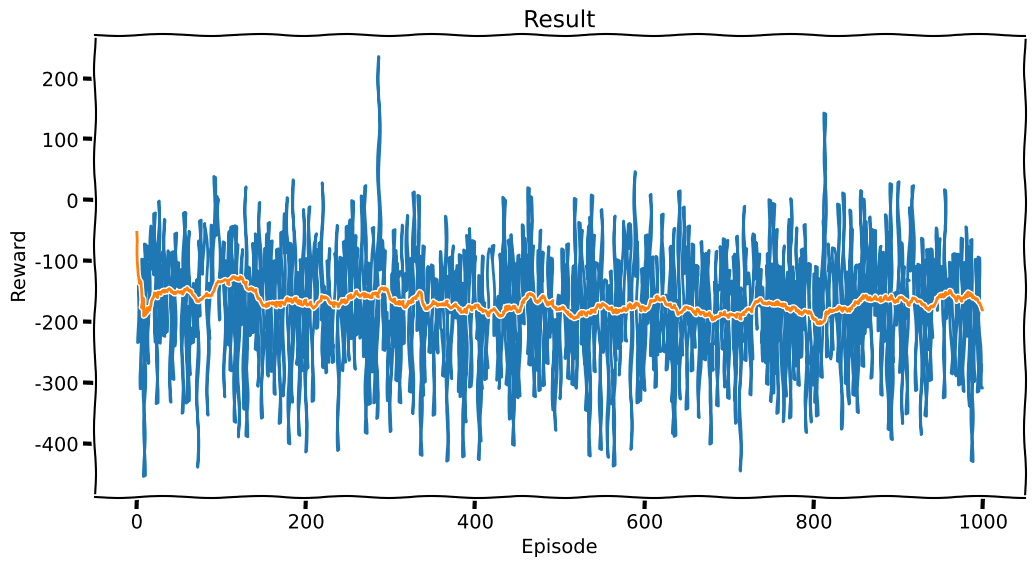

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [76]:
# Q-Learning
q_agent = QLearningAgent(
    env=env,
    state_bins=state_bins,
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
)
rewards = q_agent.train(num_episodes=num_episodes)
plot_rewards(rewards, show_result=True)
plt.ioff()
plt.show()


In [77]:
params = {
    'UPDATE_RATE': 4,
    'BUFFER_SIZE': 100000,
    'BATCH_SIZE': 64,
    'GAMMA': 0.99,
    'EPS_START': 1.0,
    'EPS_END': 0.01,
    'EPS_DECAY': 0.995,
    'TAU': 0.005,
    'LR': 1e-3,
    'HIDDEN_DIMS': [128, 128],
    'EPISODE_NUM': 1000,
    'DEVICE': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

env = gym.make("LunarLander-v3")
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

sum_of_rewards = list()

q_network = QNetwork(n_observations, n_actions, params['HIDDEN_DIMS']).to(device)
optimizer = torch.optim.Adam(q_network.parameters(), lr=params['LR'])
criterion = torch.nn.MSELoss()

memory = ReplayBuffer(params['BUFFER_SIZE'], params['BATCH_SIZE'])
agent = DQLearningAgent(
    q_network=q_network,
    memory=memory,
    optimizer= torch.optim.Adam,
    criterion=criterion,
    params=params,
    env=env,
)


Episode 100/1000, Average Reward: -171.11, Epsilon: 0.606
Episode 200/1000, Average Reward: -71.43, Epsilon: 0.367
Episode 300/1000, Average Reward: -54.66, Epsilon: 0.222
Episode 400/1000, Average Reward: -111.99, Epsilon: 0.135
Episode 500/1000, Average Reward: -77.91, Epsilon: 0.082
Episode 600/1000, Average Reward: 101.69, Epsilon: 0.049
Episode 700/1000, Average Reward: 159.76, Epsilon: 0.030
Episode 800/1000, Average Reward: 203.45, Epsilon: 0.018
Episode 900/1000, Average Reward: 234.61, Epsilon: 0.011
Episode 1000/1000, Average Reward: 246.91, Epsilon: 0.010


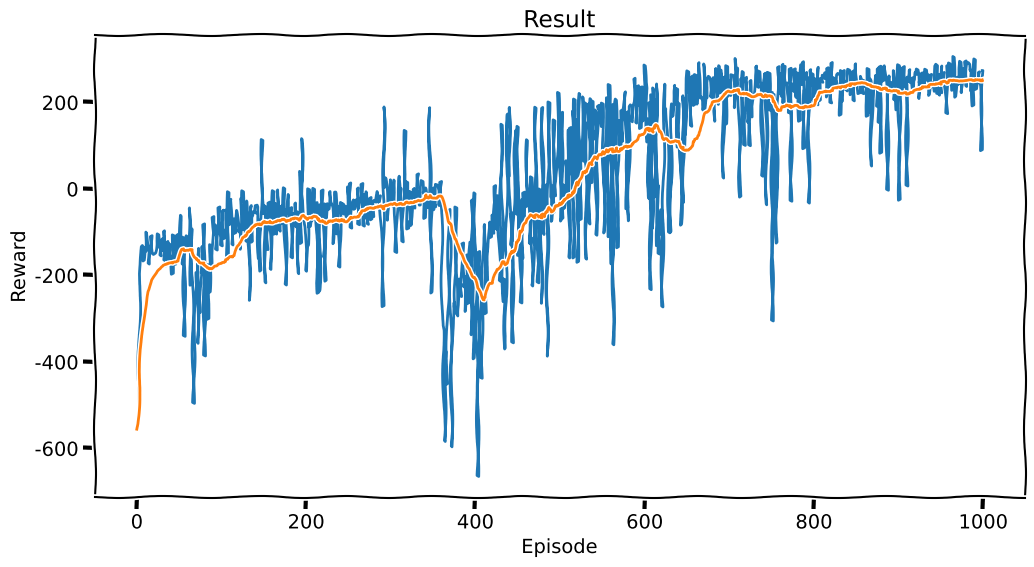

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [78]:
sum_of_rewards = agent.train(num_episodes=params['EPISODE_NUM'])
plot_rewards(sum_of_rewards, show_result=True)
plt.ioff()
plt.show()


# Evaluation

In order to evaluate the model, we use the following function to measure the average reward and it's standard deviation.

In [79]:
def evaluate_policy(env, agent, num_episodes=10):
    """
    Evaluates the performance of a policy over a number of episodes.
    Args:
        env: The environment to evaluate the policy in.
        agent: The agent to evaluate.
        num_episodes: Number of episodes to evaluate.
    Returns:
        mean_reward: Average reward over all episodes.
        std_reward: Standard deviation of rewards.
    """
    rewards = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state, greedy=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            state = next_state
        rewards.append(total_reward)

    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)

    return mean_reward, std_reward


The code below will be used for simple Q-Learning evaluation.

In [80]:
def evaluate_policy_q(env, agent, num_episodes=10):
    total_rewards = []
    for _ in range(num_episodes):
        state = agent.discretize_state(env.reset()[0])
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state, greedy=True)
            next_state_raw, reward, done, _, _ = env.step(action)
            state = agent.discretize_state(next_state_raw)
            total_reward += reward
        total_rewards.append(total_reward)

    mean_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    return mean_reward, std_reward


In [81]:
#Q-Learning reward
mean_reward, std_reward = evaluate_policy_q(env, q_agent)
print(f"mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}")

mean_reward = -130.08 +/- 24.8017


In [82]:
#DQN reward
mean_reward, std_reward = evaluate_policy(env, agent)
print(f"mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}")

mean_reward = 207.45 +/- 37.0101


In [83]:
env = gym.make("LunarLander-v3", render_mode='rgb_array')  # Ensure render_mode is set
video = create_policy_eval_video(env, agent, 'greedy_policy', num_episodes=3)
video  # Display video in Jupyter Notebook


**Question :** Which of these algorithms have better results? What causes the gap in these results?

**Answer :**
In the comparison between **Q-Learning** and **Deep Q-Learning (DQN)**, the performance of **DQN** is significantly better in environments with large or continuous state spaces, such as **LunarLander**. This advantage comes from DQN's ability to use a neural network to approximate the Q-function and generalize to unseen states, whereas Q-Learning relies on discretizing the state space, which reduces accuracy and efficiency. Additionally, techniques like **Experience Replay** and **Target Networks** in DQN contribute to more stable and efficient learning. In this specific case, **DQN** has outperformed Q-Learning by effectively managing the continuous state space and leveraging these advanced techniques.